<a href="https://colab.research.google.com/github/guilhermegfv/sprint_CienciaDeDados/blob/main/MVP_Ci%C3%AAncia_de_Dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução

O dataset escolhido foi encontrado no kaggle e diz respeito a um extenso histórico de todas corridas e sessões relevantes ao campeonato de Fórmula 1.

[Link do kaggle](https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020)

Dentro desse contexto, existem algumas variáveis importantes que afetam na performance, como:


*   Piloto (individualidade na direção)
*   Circuito e sua altitude
*   Rodada dentro do campeonato (históricamente os carros evoluem durante o ano)
*   Horário do dia (implica nas condições climáticas que não estão inclusas neste dataset)
*   E outras variáveis que serão selecionadas no notebook

Um contexto importante dentro deste estudo é que de tempos em tempos, todo o regulamento do campeonato muda, afetando significativamente a performance dos carros. A última mudança foi a partir de 2022. Por esse motivo, utilizaremos somente os anos de 2022, 2023 e 2024.

O desafio deste projeto está em estimar a melhor volta de cada piloto em cada circuito, realizando uma observação geral sobre performance de cada um em cada pista e determinadas condições.

# Preparo do dataset

Importar bibliotecas necessárias

In [1]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR


Download dos dados

In [2]:
path = kagglehub.dataset_download("rohanrao/formula-1-world-championship-1950-2020")

print("Path to dataset files:", path)
print(os.listdir(path))

Path to dataset files: /root/.cache/kagglehub/datasets/rohanrao/formula-1-world-championship-1950-2020/versions/23
['status.csv', 'sprint_results.csv', 'seasons.csv', 'constructor_results.csv', 'lap_times.csv', 'races.csv', 'pit_stops.csv', 'results.csv', 'drivers.csv', 'constructors.csv', 'constructor_standings.csv', 'circuits.csv', 'driver_standings.csv', 'qualifying.csv']


Lista das tabelas baixadas

In [3]:
lista_tabelas = os.listdir(path)
lista_tabelas = [tab.replace('.csv', '') for tab in lista_tabelas]
dataframes = {}
print(lista_tabelas)

['status', 'sprint_results', 'seasons', 'constructor_results', 'lap_times', 'races', 'pit_stops', 'results', 'drivers', 'constructors', 'constructor_standings', 'circuits', 'driver_standings', 'qualifying']


Visualização de todas tabelas e colunas em cada uma delas.
Foi necessário para selecionar apenas o necessário.

In [4]:
for tab in lista_tabelas:
    file_name = f"{tab}.csv"
    data = pd.read_csv(os.path.join(path, file_name))
    dataframes[f"{tab}"] = data
    print(f"Colunas de {tab}:")
    print(data.columns)

Colunas de status:
Index(['statusId', 'status'], dtype='object')
Colunas de sprint_results:
Index(['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid',
       'position', 'positionText', 'positionOrder', 'points', 'laps', 'time',
       'milliseconds', 'fastestLap', 'fastestLapTime', 'statusId'],
      dtype='object')
Colunas de seasons:
Index(['year', 'url'], dtype='object')
Colunas de constructor_results:
Index(['constructorResultsId', 'raceId', 'constructorId', 'points', 'status'], dtype='object')
Colunas de lap_times:
Index(['raceId', 'driverId', 'lap', 'position', 'time', 'milliseconds'], dtype='object')
Colunas de races:
Index(['raceId', 'year', 'round', 'circuitId', 'name', 'date', 'time', 'url',
       'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time',
       'quali_date', 'quali_time', 'sprint_date', 'sprint_time'],
      dtype='object')
Colunas de pit_stops:
Index(['raceId', 'driverId', 'stop', 'lap', 'time', 'duration',
       'millisecon

Funções de conversão da string de tempo para número inteiro de milisegundos, e vice versa

In [5]:
def time_to_milliseconds(time_str):
    if isinstance(time_str, str):
        try:
            minutes, rest = time_str.split(':')
            seconds, milliseconds = rest.split('.')
            total_milliseconds = (int(minutes) * 60000 + int(seconds) * 1000 + int(milliseconds))
            return total_milliseconds
        except ValueError:
            return np.nan
    # If it's not a string, return NaN (or handle it differently if needed)
    else:
        return np.nan

def milliseconds_to_time(ms):
    if pd.isna(ms):  # Check if ms is NaN
        return np.nan  # Return NaN if it is
    minutes = ms // 60000
    seconds = (ms % 60000) / 1000
    return f"{int(minutes)}:{seconds:06.3f}"

Preparo da tabela de corridas. Filtro de temporadas e seleção de colunas.

Também foi salvo em uma lista as corridas das temporadas selecionadas, a fim de filtrar as demais tabelas.

In [6]:
df_races = dataframes['races']
df_races = df_races[['raceId', 'year', 'circuitId','round','name','date','time','quali_time']]
df_races = df_races[df_races['year'] >= 2022]
df_races.rename(columns={'time': 'time_of_day'}, inplace=True)

print(df_races)


corridas = df_races['raceId'].unique()
corridas = corridas.tolist()
print(corridas)

      raceId  year  circuitId  round                       name        date  \
1036    1074  2022          3      1         Bahrain Grand Prix  2022-03-20   
1058    1075  2022         77      2   Saudi Arabian Grand Prix  2022-03-27   
1059    1076  2022          1      3      Australian Grand Prix  2022-04-10   
1060    1077  2022         21      4  Emilia Romagna Grand Prix  2022-04-24   
1061    1078  2022         79      5           Miami Grand Prix  2022-05-08   
...      ...   ...        ...    ...                        ...         ...   
1120    1140  2024         32     20     Mexico City Grand Prix  2024-10-27   
1121    1141  2024         18     21       São Paulo Grand Prix  2024-11-03   
1122    1142  2024         80     22       Las Vegas Grand Prix  2024-11-23   
1123    1143  2024         78     23           Qatar Grand Prix  2024-12-01   
1124    1144  2024         24     24       Abu Dhabi Grand Prix  2024-12-08   

     time_of_day quali_time  
1036    15:00:00   15

Preparo da tabela de tempos de volta, mas até o momento não utilizada.

In [7]:
df_lap_times = dataframes['lap_times']
df_lap_times = df_lap_times[df_lap_times['raceId'].isin(corridas)]
print(df_lap_times)

        raceId  driverId  lap  position      time  milliseconds
514592    1074       844    1         1  1:39.070         99070
514593    1074       844    2         1  1:37.853         97853
514594    1074       844    3         1  1:38.272         98272
514595    1074       844    4         1  1:38.414         98414
514596    1074       844    5         1  1:38.471         98471
...        ...       ...  ...       ...       ...           ...
575024    1131       858   65        19  1:10.742         70742
575025    1131       858   66        19  1:10.855         70855
575026    1131       858   67        19  1:12.454         72454
575027    1131       858   68        19  1:13.607         73607
575028    1131       858   69        19  1:11.489         71489

[60437 rows x 6 columns]


Preparo da tabela de resultados, filtrando e convertendo tempo em string para tempo em milissegundos.

In [8]:
df_results = dataframes['results']
print(df_results.columns)
df_results = df_results[df_results['raceId'].isin(corridas)]
df_results = df_results[['raceId','driverId','constructorId','positionOrder','time','milliseconds','fastestLapTime']]

df_results['fastestLapTime' + "_ms"] = df_results['fastestLapTime'].apply(time_to_milliseconds)

print(df_results)


Index(['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid',
       'position', 'positionText', 'positionOrder', 'points', 'laps', 'time',
       'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId'],
      dtype='object')
       raceId  driverId  constructorId  positionOrder         time  \
25400    1074       844              6              1  1:37:33.584   
25401    1074       832              6              2       +5.598   
25402    1074         1            131              3       +9.675   
25403    1074       847            131              4      +11.211   
25404    1074       825            210              5      +14.754   
...       ...       ...            ...            ...          ...   
26514    1132       839            214             16           \N   
26515    1132       815              9             17           \N   
26516    1132       855             15             18           \N   
26517    1132       84

Tabela de pilotos, com apenas as colunas para tradução co ID para código de cada um, a fim de reconhecimento.

In [9]:
df_drivers = dataframes['drivers']
df_drivers = df_drivers[['driverId', 'code']]
print(df_drivers)

     driverId code
0           1  HAM
1           2  HEI
2           3  ROS
3           4  ALO
4           5  KOV
..        ...  ...
854       856  DEV
855       857  PIA
856       858  SAR
857       859  LAW
858       860  BEA

[859 rows x 2 columns]


Tabela dos circuitos, necessária para utilizar a variável altitude no modelo.

In [10]:
df_circuits = dataframes['circuits']
df_circuits = df_circuits[['circuitId','name','alt']]

print(df_circuits)

    circuitId                                  name  alt
0           1        Albert Park Grand Prix Circuit   10
1           2          Sepang International Circuit   18
2           3         Bahrain International Circuit    7
3           4        Circuit de Barcelona-Catalunya  109
4           5                         Istanbul Park  130
..        ...                                   ...  ...
72         75    Autódromo Internacional do Algarve  108
73         76  Autodromo Internazionale del Mugello  255
74         77               Jeddah Corniche Circuit   15
75         78          Losail International Circuit   12
76         79         Miami International Autodrome    0

[77 rows x 3 columns]


Tabela dos treinos classificatórios. Em cada sessão, cada piloto pode fazer até 3 tempos (q1, q2, q3). Portanto, foi criada uma variável nova com o melhor tempo entre os 3 e utilizá-los no modelo.

In [11]:
df_qualifying = dataframes['qualifying']
df_qualifying = df_qualifying[['qualifyId','raceId','driverId','position','q1','q2','q3']]
df_qualifying = df_qualifying[df_qualifying['raceId'].isin(corridas)]

for col in ["q1", "q2", "q3"]:
    df_qualifying[col + "_ms"] = df_qualifying[col].apply(time_to_milliseconds)

df_qualifying["fastest_qualifying_ms"] = df_qualifying[["q1_ms", "q2_ms", "q3_ms"]].min(axis=1)

df_qualifying["fastest_qualifying"] = df_qualifying["fastest_qualifying_ms"].apply(milliseconds_to_time)

print(df_qualifying)

       qualifyId  raceId  driverId  position        q1        q2        q3  \
9135        9176    1074       844         1  1:31.471  1:30.932  1:30.558   
9136        9177    1074       830         2  1:31.785  1:30.757  1:30.681   
9137        9178    1074       832         3  1:31.567  1:30.787  1:30.687   
9138        9179    1074       815         4  1:32.311  1:31.008  1:30.921   
9139        9180    1074         1         5  1:32.285  1:31.048  1:31.238   
...          ...     ...       ...       ...       ...       ...       ...   
10249      10307    1132       822        16  1:32.431        \N        \N   
10250      10308    1132       825        17  1:32.905        \N        \N   
10251      10309    1132       839        18  1:34.557        \N        \N   
10252      10310    1132       815        19  1:38.348        \N        \N   
10253      10311    1132       842        20  1:39.804        \N        \N   

         q1_ms    q2_ms    q3_ms  fastest_qualifying_ms fastest

Agora a criação do dataframe 'df', contendo todas as informações separadas anteriormente.

In [12]:
df = pd.merge(df_results, df_races, on ='raceId', how='left')

In [13]:
df = pd.merge(df, df_circuits, on='circuitId', how='left')

In [14]:
df = pd.merge(df, df_qualifying, how='left',
                  left_on=['raceId', 'driverId'],
                  right_on=['raceId', 'driverId'])

In [15]:
df = df[['fastestLapTime_ms','driverId','circuitId','constructorId','round','alt','fastest_qualifying_ms']]

In [16]:
print(df)

      fastestLapTime_ms  driverId  circuitId  constructorId  round  alt  \
0               94570.0       844          3              6      1    7   
1               95740.0       832          3              6      1    7   
2               96228.0         1          3            131      1    7   
3               96302.0       847          3            131      1    7   
4               96623.0       825          3            210      1    7   
...                 ...       ...        ...            ...    ...  ...   
1114            90875.0       839          9            214     12  153   
1115            89707.0       815          9              9     12  153   
1116            91014.0       855          9             15     12  153   
1117            91298.0       847          9            131     12  153   
1118                NaN       842          9            214     12  153   

      fastest_qualifying_ms  
0                   90558.0  
1                   90687.0  
2        

# Preparo do modelo

Ajuste de variáveis categóricas e separação do X e Y, ou seja, variáveis de entrada e a variável alvo.

In [17]:
data = df.dropna()

data_encoded = pd.get_dummies(data, columns=['circuitId','driverId','constructorId'], drop_first=True)

X = data_encoded.drop('fastestLapTime_ms', axis=1)
y = data_encoded['fastestLapTime_ms']

Separação da base em treino/teste, além de especificar a validação cruzada. Número de partições estabelecido em 20.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

num_particoes = 10
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=33)

Seleção dos modelos a serem utilizados para teste.

Os modelos lasso e SVM foram descartados por apresentarem resultados muito distantes.

In [19]:
models = []
results = []
names = []

models.append(('RF', RandomForestRegressor()))
models.append(('LR', LinearRegression()))
models.append(('Ridge', Ridge()))
#models.append(('Lasso', Lasso()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
#models.append(('SVM', SVR()))

for name, model in models:
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
  results.append(cv_results)
  names.append(name)
  msg = "%s: MSE %0.2f (%0.2f) - RMSE %0.2f" % (name, abs(cv_results.mean()), cv_results.std(), np.sqrt(abs(cv_results.mean())))
  print(msg)

RF: MSE 3719616.57 (2641478.19) - RMSE 1928.63
LR: MSE 5066864.87 (3062202.00) - RMSE 2250.97
Ridge: MSE 5661834.15 (3252007.88) - RMSE 2379.46
KNN: MSE 14042715.56 (4071628.32) - RMSE 3747.36
CART: MSE 6810213.01 (5995834.18) - RMSE 2609.64


# Análise de Resultados

Gerando boxplot para o MSE de cada modelo, assim podendo comparar a dispersão do resultado de cada um.

Percebemos que o modelo de regression forest tem o menor valor encontrado, apesar da sua mediana estar mais alta que a mediana do modelo de regressão linear.

Por isso, seguiremos analisando apenas estes modelos a partir daqui.

## Boxplot comparativo entre 5 modelos pré-escolhidos

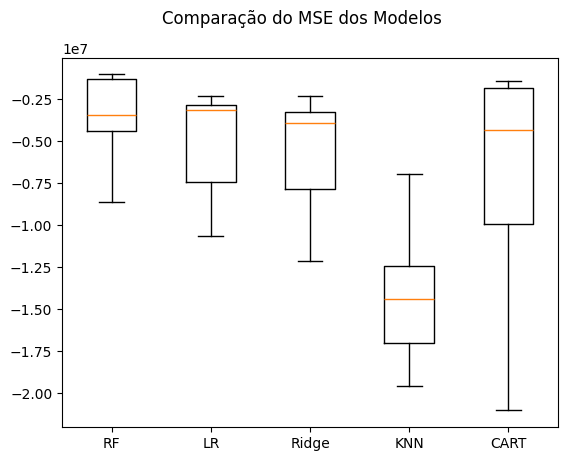

In [20]:
fig = plt.figure()
fig.suptitle('Comparação do MSE dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Regressão

Retreinando um modelo com regressão linear sem validação cruzada.

Usaremos os coeficientes para entender um pouco da relação entre as variáveis e o melhor tempo de volta para cada situação.

In [21]:
model_rl = LinearRegression()
model_rl.fit(X_train, y_train)

LinearRegression()

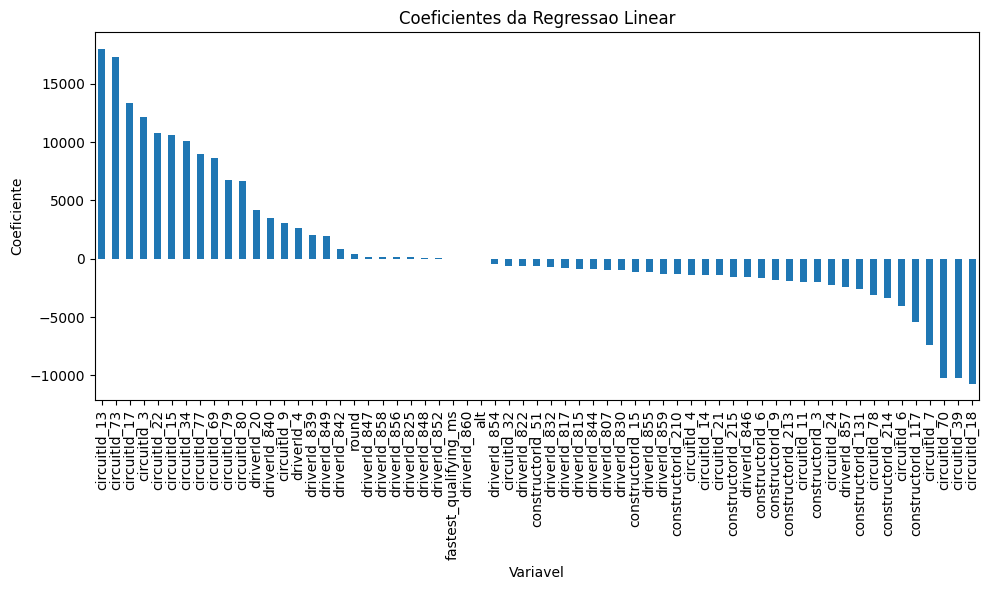

In [22]:
coefs = pd.Series(model_rl.coef_, index=X_train.columns)

coefs_df = coefs.to_frame(name='coefficients')
coefs_df.index.name = 'feature'
coefs_df = coefs_df.sort_values('coefficients', ascending=False)

plt.figure(figsize=(10, 6))
coefs_df['coefficients'].plot(kind='bar')
plt.title('Coeficientes da Regressao Linear')
plt.xlabel('Variavel')
plt.ylabel('Coeficiente')
plt.tight_layout()
plt.show()

Aqui temos um gráfico onde podemos analisar o impacto de variáveis categóricas no resultado final da volta mais rápida.

Especificamente sobre os circuitos, é perceptível identificar os circuitos com volta mais rápida e mais lenta. Por exemplo, os circuitos com id: 13, 73 e 17 tem volta muito mais lentas que a média. Enquanto os circuitos 70, 39 e 18, mais rápidas.

Sobre construtores, percebemos uma superioridade da construtora_id 117, em comparação a 51, por exemplo. Isto é outro fato que reflete a realidade, visto que cada construtora possui um carro diferente com performance exclusiva.

O mesmo raciocínio para os pilotos, onde o driver_id 857 por exemplo tende a ter voltas mais rápidas bem melhores que o driver_id 840.

## Random Forest

Aqui vamos regerar o modelo de Random Forest sem validação cruzada, afim de trazer uma ilustração gráfica sobre o impacto das variáveis.

In [25]:
model_rf = RandomForestRegressor(random_state=42, n_estimators=100)
model_rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [26]:
y_pred_rf = model_rf.predict(X_test)

Uma análise rápida do RMSE diz um pouco sobre os resultados. A unidade em questão é milissegundos, ou seja, o RMSE está em 2,8s. Dentro do universo da fórmula 1, este número pode ser interpretado de algumas formas.

Dentro do mesmo circuito e com condições parecidas (horário, rodada, equipe), um intervalo de 2s é suficiente para abranger todas as melhores voltas dos pilotos, salvo raras ocasiões.

Porém, variando-se o circuito, e somado a todas outras condições, 2s é um intervalo muito pequeno ao tentar prever a melhor volta em uma determinada perspectiva, visto que existe uma grande variação local a local.

In [27]:
# Avaliar desempenho
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2 = r2_score(y_test, y_pred_rf)

print(f"RMSE: {rmse}")
print(f"R²: {r2}")

RMSE: 2870.8379244615817
R²: 0.9427689493302894


In [28]:
!pip install shap
import shap

explainer = shap.TreeExplainer(model_rf)
shap_values = explainer.shap_values(X)

Aqui podemos fazer uma breve análise sobre o impacto das variáveis no resultado final.

Como era de se esperar, o tempo da melhor volta na sessão de qualifying tem total conexão com o melhor tempo de volta na corrida. São dois tempos em que circuito, piloto e equipe afetam de forma parecidas.

Este valor encontrado era esperado dentro do modelo.

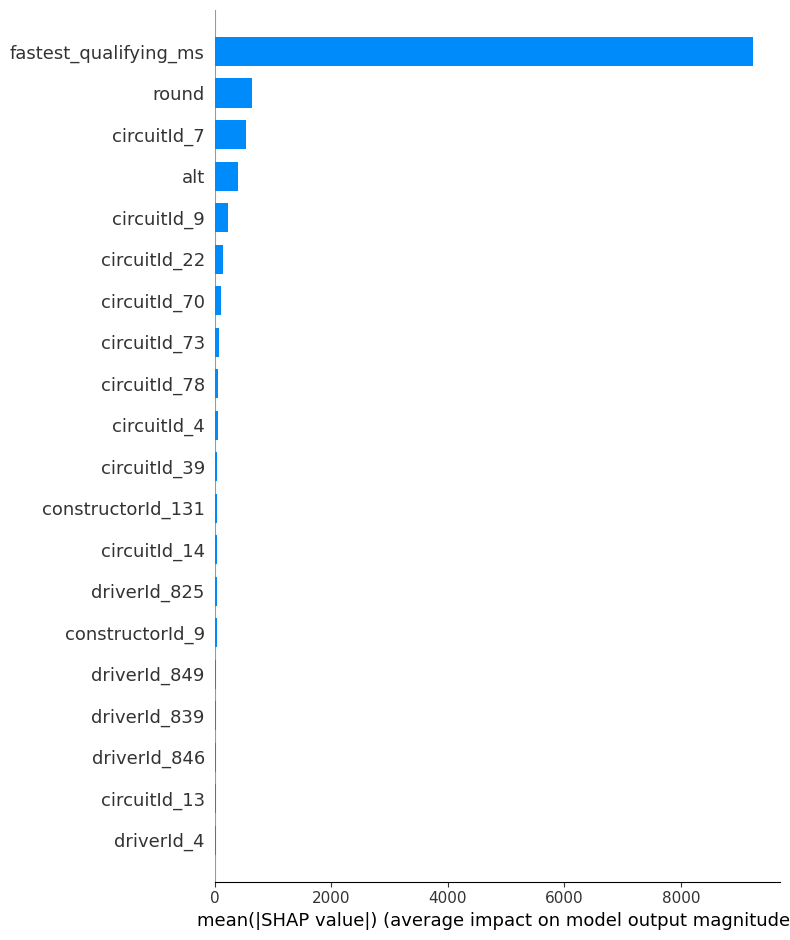

In [29]:
shap.summary_plot(shap_values, X, plot_type="bar")

Abaixo podemos analisar o impacto de cada variável, tendendo o resultado final para cima ou para baixo. Como descrito acima, a melhor volta no qualifying afeta para ambas direções o resultados.

Já a rodada dentro do campeonato por exemplo, tende a afetar para cima a duração da maior volta. Isto pode ocorrer por diversos motivos dentro do contexto da F1, como: carros e equipamentos mais desgastados, menor discrepância entre equipes, e circuitos mais exigentes no final da temporada.

Podemos confirmar os circuitos 7 e 9 como os mais rápidos da temporada, enquanto por exemplo o piloto driver_825 tende a ser o mais devagar entre seus concorrentes.

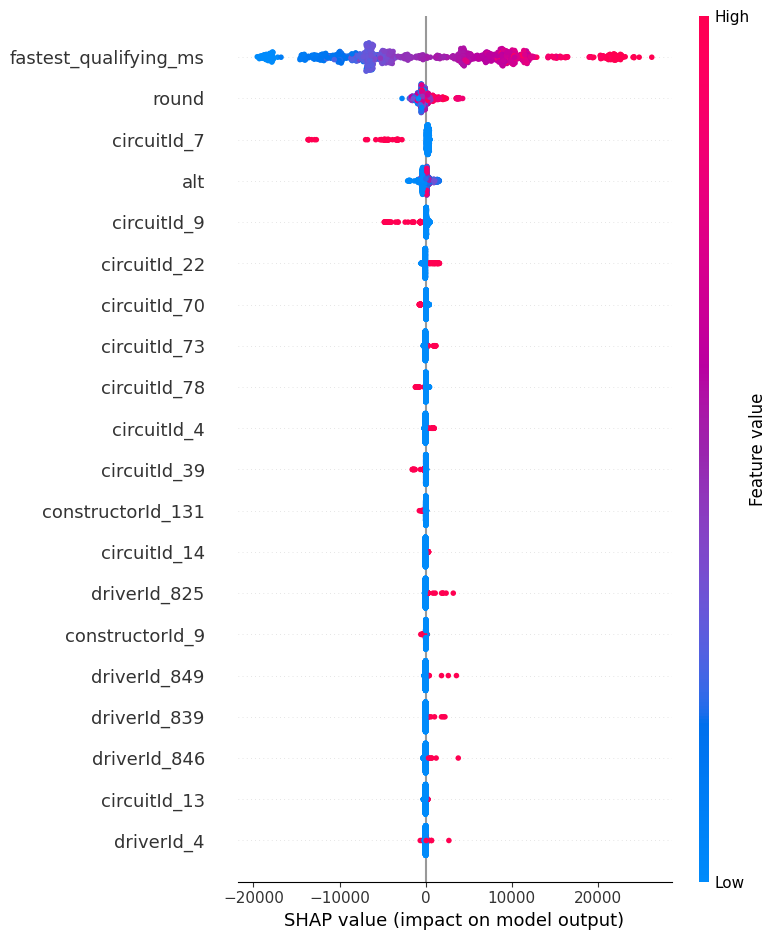

In [30]:
shap.summary_plot(shap_values, X)

# Considerações Finais

A base de dados encontrada no kaggle, apesar de faltar algumas informações climáticas que poderiam ser adicionadas com outra API, é muito completa e possui muitos dados para criação de modelos e exploração desse universo.

A Fórmula 1, pela complexidade e grande variedade de elementos, permite uma série de possíveis desafios e modelos a serem desenvolvidos. Existem perguntas específicas para equipes, pilotos e pistas que podem ser amplamente respondidas. Além disso, nosso estudo foi baseado na melhor volta, enquanto o histórico possui o tempo de todas as voltas, o que permitiria uma análise muito mais profunda.

Os modelos tiveram resultados relativamente parecidos, e algumas considerações sobre a escolha de variáveis foram percebidas. O trabalho futuro provavelmente seria na escolha delas, antes de se escolher o modelo ideal.

Por termos 3 variáveis categóricas muito expressivas (circuito, piloto e equipe), a opção de se plotar a Random Forest e também a árvore de decisão ficou inviável vide a quantidade de elementos e terminações que seriam representadas. Mas isto reforça a ideia que modelos mais específicos tenderiam a ser mais assertivos.

O tempo encontrado em praticamente todos os modelos (entre 2s e 3s), se tornou um resultado dúbio frente a grande variedade de circuitos. Existem pistas com tempo de volta entre 65s, enquanto outras com 115s. Ou seja, realizando um trabalho de modelos por pistas, teríamos uma precisão frente ao tempo de volta muito mais assertiva.